## This notebook is made for comparison between dataset provided by loading the whole one into notebook vs the using a generator

HERE photos are in grayscale

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13249832049308162826, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 356122624
 locality {
   bus_id: 1
 }
 incarnation: 1486328241421701552
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [13]:
width, height = 64, 64
train_data_dir = '../zdjecia_gen/train'
test_data_dir = '../zdjecia_gen/test'
nb_train_samples = 40320
nb_test_samples = 10080
epochs = 20
batch_size = 256

input_shape = (width, height, 1)

In [4]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(6, activation='softmax'))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
# summarize model and apply checkpoints
print(model.summary())
filepath = 'comparison_gray-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
__________

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(width, height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    classes=['1', '2', '3', '4', '5', '6'],
    shuffle=True,
    seed=2018)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width, height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    classes=['1', '2', '3', '4', '5', '6'],
    shuffle=True,
    seed=2018)

Found 40320 images belonging to 6 classes.
Found 10080 images belonging to 6 classes.


In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list,
    shuffle=True,
    validation_data=test_generator,
    validation_steps=nb_test_samples // batch_size)

Epoch 1/20
157/157 [==============================] - 16s 104ms/step - loss: 1.2128 - acc: 0.4980 - val_loss: 0.8271 - val_acc: 0.7006
Epoch 2/20
157/157 [==============================] - 16s 104ms/step - loss: 0.8272 - acc: 0.6762 - val_loss: 0.6477 - val_acc: 0.7534
Epoch 3/20
157/157 [==============================] - 16s 103ms/step - loss: 0.5850 - acc: 0.7788 - val_loss: 0.4391 - val_acc: 0.8405
Epoch 4/20
157/157 [==============================] - 16s 104ms/step - loss: 0.4411 - acc: 0.8391 - val_loss: 0.4024 - val_acc: 0.8490
Epoch 5/20
157/157 [==============================] - 16s 105ms/step - loss: 0.3648 - acc: 0.8705 - val_loss: 0.2184 - val_acc: 0.9238
Epoch 6/20
157/157 [==============================] - 16s 105ms/step - loss: 0.2694 - acc: 0.9019 - val_loss: 0.1967 - val_acc: 0.9251
Epoch 7/20
157/157 [==============================] - 16s 105ms/step - loss: 0.2362 - acc: 0.9181 - val_loss: 0.2315 - val_acc: 0.9207
Epoch 8/20
157/157 [==============================] - 1

In [16]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [17]:
score = model.evaluate_generator(test_generator)

In [18]:
print("Accuracy: %.2f%%" % (score[1]*100))
print('Test loss:', score[0])
print('Test accuracy', score[1])

Accuracy: 98.12%
Test loss: 0.05799690048609461
Test accuracy 0.9812499998107789


In [19]:
model_json = model.to_json()
with open('comparison_gray_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('comparison_gray_weights.h5')
print('Saved model weights')

Saved model weights


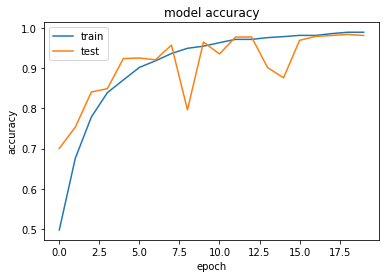

In [20]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

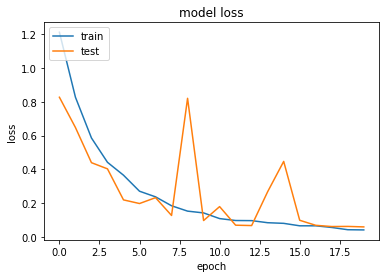

In [21]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()